In [1]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
print(text)

you say goodbye and i say hello .


In [2]:
words = text.split(' ')
print(words)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [3]:
word_to_id = {}
id_to_word = {}

for word in words :
    if word not in word_to_id :
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [4]:
print(id_to_word)
print(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [5]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


In [6]:
# コーパスの前処理を行う
def preprocess(text) :
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words :
        if word not in word_to_id :
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [7]:
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
# コーパスより共起行列を作る
def create_co_matrix(corpus, vocab_siz, window_size=1) :
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus) :
        for i in range(1, window_size+1) :
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0 :
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size :
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [9]:
# コサイン類似度(0ベクトルが入ると0除算が発生してしまう)
def cos_similar(x,y) :
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx,ny)

In [10]:
# コサイン類似度(0除算対策)
def cos_similarity(x,y,eps=1e-8) :
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx,ny)

In [11]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['goodbye']]
c1 = C[word_to_id['hello']]
print(cos_similarity(c0,c1))

0.499999992929


In [12]:
# ある単語に対して類似した単語を上位から順に表示する
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5) :
    # クエリを取り出す
    if query not in word_to_id :
        print('query is not found')
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # コサイン類似度の算出
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size) :
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # コサイン類似度の結果から、その値を高い順に出力
    count = 0
    for i in (-1 * similarity).argsort() :
        if id_to_word[i] == query :
            continue
        print(f'{id_to_word[i]} : {similarity[i]}')
        
        count += 1
        if count >= top :
            return

In [13]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
goodbye : 0.7071067691154799
i : 0.7071067691154799
hello : 0.7071067691154799
say : 0.0
and : 0.0


In [14]:
# 正の相互情報遼PPMI
def ppmi(C, verbose=False, eps=1e-8) :
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]) :
        for j in range(C.shape[1]) :
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
            M[i,j] = max(0,pmi)
            
            if verbose :
                cnt += 1
                if cnt% (total//100) == 0 :
                    print(f'{100*cnt/total} done')
    return M

In [15]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[ 0.     1.807  0.     0.     0.     0.     0.   ]
 [ 1.807  0.     0.807  0.     0.807  0.807  0.   ]
 [ 0.     0.807  0.     1.807  0.     0.     0.   ]
 [ 0.     0.     1.807  0.     1.807  0.     0.   ]
 [ 0.     0.807  0.     1.807  0.     0.     0.   ]
 [ 0.     0.807  0.     0.     0.     0.     2.807]
 [ 0.     0.     0.     0.     0.     2.807  0.   ]]


In [16]:
# SVDによる次元削減
U, S, V  = np.linalg.svd(W)

print(C[0])
print(W[0])

print(U[0])
print(U[0,:2])

[0 1 0 0 0 0 0]
[ 0.     1.807  0.     0.     0.     0.     0.   ]
[ -3.409e-01  -1.110e-16  -3.886e-16  -1.205e-01   0.000e+00   9.323e-01
   2.226e-16]
[ -3.409e-01  -1.110e-16]


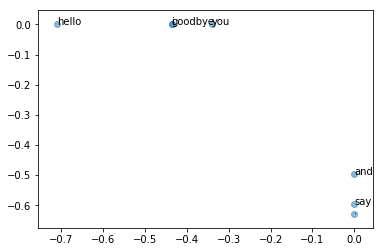

In [17]:
# 2次元のベクトルをプロット
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items() :
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [18]:
import sys
sys.path.append('./samplecode')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size : ', len(corpus))
print('corpus[:30] : ', corpus[:30])
print()
print('id_to_word[0] : ', id_to_word[0])
print('id_to_word[1]', id_to_word[1])
print('id_to_word[2]', id_to_word[2])
print()
print("word_to_id['car'] : ", word_to_id['car'])
print("word_to_id['happy'] : ", word_to_id['happy'])
print("word_to_id['lexus'] : ", word_to_id['lexus'])

corpus size :  929589
corpus[:30] :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]

id_to_word[0] :  aer
id_to_word[1] banknote
id_to_word[2] berlitz

word_to_id['car'] :  3856
word_to_id['happy'] :  4428
word_to_id['lexus'] :  7426


In [21]:
# PTBデータ・セットでの評価

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('calculating co_occurance')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD')
try :
    from sklearn.utils.extmath import randomized_svd
    U, S, V  = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
    
except ImportError :
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys :
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

calculating co_occurance
calculating PPMI ...
1.0 done
2.0 done
3.0 done
4.0 done
5.0 done
6.0 done
7.0 done
8.0 done
9.0 done
10.0 done
11.0 done
12.0 done
13.0 done
14.0 done
15.0 done
16.0 done
17.0 done
18.0 done
19.0 done
20.0 done
21.0 done
22.0 done
23.0 done
24.0 done
25.0 done
26.0 done
27.0 done
28.0 done
29.0 done
30.0 done
31.0 done
32.0 done
33.0 done
34.0 done
35.0 done
36.0 done
37.0 done
38.0 done
39.0 done
40.0 done
41.0 done
42.0 done
43.0 done
44.0 done
45.0 done
46.0 done
47.0 done
48.0 done
49.0 done
50.0 done
51.0 done
52.0 done
53.0 done
54.0 done
55.0 done
56.0 done
57.0 done
58.0 done
59.0 done
60.0 done
61.0 done
62.0 done
63.0 done
64.0 done
65.0 done
66.0 done
67.0 done
68.0 done
69.0 done
70.0 done
71.0 done
72.0 done
73.0 done
74.0 done
75.0 done
76.0 done
77.0 done
78.0 done
79.0 done
80.0 done
81.0 done
82.0 done
83.0 done
84.0 done
85.0 done
86.0 done
87.0 done
88.0 done
89.0 done
90.0 done
91.0 done
92.0 done
93.0 done
94.0 done
95.0 done
96.0 done
97.